<a href="https://colab.research.google.com/github/rtajeong/AI_Cluster_MSAC/blob/main/gg_141_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EA%B0%9D%EC%B2%B4_%EC%9D%B8%EC%8B%9D_%ED%83%90%EC%A7%80_%EB%AA%A8%EB%8D%B8_1_(Faster_R_CNN)_v1_ing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Example
- face Mask detection using Faster RCNN
- https://pseudo-lab.github.io/Tutorial-Book/chapters/object-detection/Ch2-EDA.html

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# 데이터셋 로드

In [2]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 19 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 11.63 KiB | 52.00 KiB/s, done.
Resolving deltas: 100% (18/18), done.


- 코드 설명
  - 명령줄에서 데이터셋 키를 입력하면, 해당 Google Drive 파일을 다운로드하여 지정된 이름으로 저장한다.
  - 파일 이름과 저장 경로 매핑
  - Google Drive 파일 ID 매핑
  - 다운로드 함수
  - 명령줄 인자 처리
  - 실행

In [3]:
!cat Tutorial-Book-Utils/PL_data_loader.py

# taken from this repo: https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

import gdown
import argparse

file_destinations = {'FaceMaskDetection':'Face Mask Detection.zip',
              'COVIDTimeSeries':'COVIDTimeSeries.zip',
              'GAN-Colorization':'Victorian400-GAN-colorization-data.zip',
              'NLP-QG':'CoNLL+BEA_corrected_essays.pkl'}

file_id_dic = {'FaceMaskDetection':'16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7',
              'COVIDTimeSeries':'1B36Djko-f0LtVxSaBEVYosLTTsu0qtsh',
              'GAN-Colorization':'1dZxoBIWmbuF-Oy_XZoS1z9EjPJwkTmy6',
              'NLP-QG':'1QccVdDR5ebpPV8tLA7XkY6JmUjM1TYsw'}

def download_file_from_google_drive(id_, destination):
    url = f'https://drive.google.com/uc?id={id_}'
    output = destination
    gdown.download(url, output, quiet=False)
    print(f'{output} download complete!')
    
parser = argparse.ArgumentParser(description = 'data loader for PseudoLab Tutorial Book')

parser.ad

- 구글 드라이브에 있는 파일을 다운로드 하는 함수
- --data 파라미터에 FaceMaskDetection을 입력함으로써 마스크 착용 탐지 모델 구축에 활용할 데이터를 받는다

In [4]:
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

Downloading...
From (original): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
From (redirected): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7&confirm=t&uuid=2ba2fa60-d165-4cc1-8fb8-19c39e5fc2b8
To: /content/Face Mask Detection.zip
100% 417M/417M [00:13<00:00, 32.0MB/s]
Face Mask Detection.zip download complete!


In [5]:
!unzip -q Face\ Mask\ Detection.zip

- -q : quiet mode
- “annotations” 폴더와 “images” 폴더가 생성된다
- “annotations” 폴더에는 이미지별 의료용 마스크 위치 좌표가 저장되어 있고, “images” 폴더에는 이미지가 저장됨.

# 데이터셋 확인
- “images” 폴더에는 이미지 파일이 0부터 852까지 있으며, “annotations” 폴더에는 xml 파일이 0부터 852 가 있다.
- “annotations” 폴더 안에 있는 xml 파일들은 각각의 이미지 파일의 정보를 가지고 있다. 예를 들어, maksssksksss307.xml 파일을 살펴보면,

- annotation file format (예시: Pascal VOC XML): Labeling Tool 사용 (LabelImg, Labelme, CVAT, Roboflow, etc.)
  - filename: 이미지 파일 이름
  - size: 이미지 크기 (width, height, depth)
  - object: 이미지 안에 있는 객체 정보
    - name: 객체 클래스 (예: "dog", "car")
    - bndbox: 객체 위치를 나타내는 bounding box 좌표 (xmin, ymin, xmax, ymax)

In [6]:
!cat ./annotations/maksssksksss307.xml


<annotation>
    <folder>images</folder>
    <filename>maksssksksss307.png</filename>
    <size>
        <width>400</width>
        <height>226</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>mask_weared_incorrect</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>3</xmin>
            <ymin>65</ymin>
            <xmax>96</xmax>
            <ymax>163</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>146</xmin>
            <ymin>28</ymin>
            <xmax>249</xmax>
            <ymax>140</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <trunca

- 처음에 폴더명과 파일명이 나오며, 이미지 크기 정보가 포함되어 있다.
- object안 코드:
  - class 종류: mask_weared_incorrect, with_mask, without_mask
  - bounding box: xmin, ymin, xmax, ymax
- 이 파일은 마스크 착용 여부 데이터셋의 일부로, 이미지 안에 있는 사람 얼굴을 세 가지 클래스(with_mask, without_mask, mask_weared_incorrect)로 라벨링한 것.
- 좌표(xmin, ymin, xmax, ymax)는 객체의 위치를 나타내며, 딥러닝 모델(예: YOLO, Faster R-CNN 등)이 학습할 때 사용.

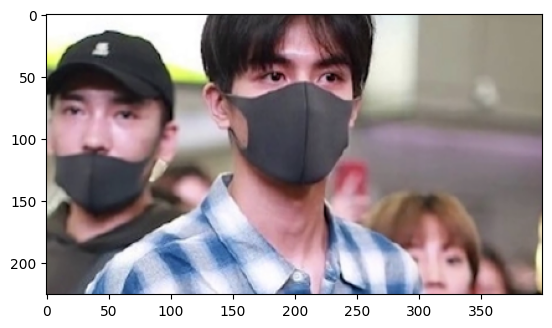

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('./images/maksssksksss307.png')
plt.imshow(img)  # one with_mask, one_weird_mask, one no_mask

In [8]:
import os
import random
import numpy as np
import shutil    # 파일과 디렉터리를 복사·이동·삭제하는 고수준(high-level) 함수들을 제공하는 모듈
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations

random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)  # recursively moves a file or directory (src)->(dst)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


In [9]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [10]:
def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj.find('name').text == "with_mask":
        return 1 + adjust_label
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2 + adjust_label
    return 0 + adjust_label

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image_from_output(img, annotation):

    # img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        else :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [11]:
img_list = os.listdir('images')
annot_list = os.listdir('images')
img_list.index('maksssksksss307.png')

259

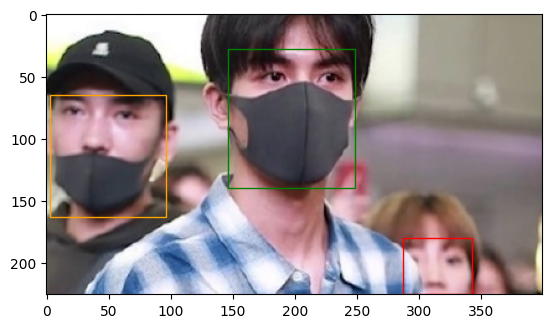

In [12]:
bbox = generate_target('./annotations/maksssksksss307.xml')
img = mpimg.imread('./images/maksssksksss307.png')
plot_image_from_output(img, bbox)

In [13]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): # special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

# 모델 불러오기
- torchvision.models.detection 에서 Faster R-CNN API(torchvision.models.detection.fasterrcnn_resnet50_fpn)를 제공
- COCO 데이터셋을 ResNet50으로 pre-trained한 모델을 제공하고 있으며, pretrained=True/False로 설정

- 이후 모델을 불러올 때는 num_classes에 원하는 클래스 개수를 설정하고 모델을 사용하면 된다.
- Faster R-CNN 사용 시 주의할 점은 background 클래스를 포함한 개수를 num_classes에 명시해주어야 한다. 즉, 실제 데이터셋의 클래스 개수에 1개를 늘려 background 클래스를 추가해주어야 합니다.

In [14]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# 전이 학습
- background 클래스를 포함하여 num_classes를 4로 설정 (마지막에 classification layer를 4개의 클래스(배경 포함)로 밎춤)

In [15]:
# 모델 초기화 및 디바이스 설
model = get_model_instance_segmentation(4)  # 모델을 불러옴 (Faster-RCNN)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 198MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

- 위의 출력되는 결과를 통해 Fastser R-CNN이 어떤 layer들로 구성되어 있는지 알 수 있다.

In [16]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [17]:
# train

print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 78.10298156738281, time : 244.24896359443665
epoch : 2, Loss : 50.005279541015625, time : 244.7794370651245
epoch : 3, Loss : 42.152565002441406, time : 244.8304524421692
epoch : 4, Loss : 35.971309661865234, time : 244.81645345687866
epoch : 5, Loss : 32.40440368652344, time : 244.7631130218506
epoch : 6, Loss : 31.253358840942383, time : 244.91753435134888
epoch : 7, Loss : 30.830425262451172, time : 245.02064156532288
epoch : 8, Loss : 30.11406707763672, time : 244.8534164428711
epoch : 9, Loss : 25.493389129638672, time : 245.21672296524048
epoch : 10, Loss : 23.852399826049805, time : 245.07179641723633


In [18]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [19]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

# 예측

In [20]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [21]:
with torch.no_grad():
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)  # threshold 0.5
        print(pred)
        break

[{'boxes': tensor([[213.5001,  59.6581, 249.4690, 100.4841],
        [118.2289,   2.5378, 132.2308,  18.1899]], device='cuda:0'), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9482, 0.8401], device='cuda:0')}, {'boxes': tensor([[219.5255, 100.0187, 257.9390, 138.7443],
        [131.9962, 109.3237, 174.7872, 154.0509],
        [165.8493,  89.9274, 178.9970, 109.4596],
        [ 41.9856, 108.9947,  66.0715, 141.1458],
        [304.1369, 131.2498, 331.1903, 159.5520],
        [ 30.3826,  89.5300,  44.7514, 103.7429],
        [ 84.0147,  84.9716,  94.3279,  96.6719],
        [  3.4171, 103.8638,  22.0395, 128.3024],
        [  2.7166, 104.6304,  21.6496, 127.7869]], device='cuda:0'), 'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1, 2], device='cuda:0'), 'scores': tensor([0.9944, 0.9922, 0.9675, 0.9618, 0.9556, 0.9465, 0.9048, 0.5802, 0.5076],
       device='cuda:0')}]


In [30]:
len(pred)

2

In [32]:
pred[0]

{'boxes': tensor([[213.5001,  59.6581, 249.4690, 100.4841],
         [118.2289,   2.5378, 132.2308,  18.1899]], device='cuda:0'),
 'labels': tensor([2, 2], device='cuda:0'),
 'scores': tensor([0.9482, 0.8401], device='cuda:0')}

In [33]:
pred[1]

{'boxes': tensor([[219.5255, 100.0187, 257.9390, 138.7443],
         [131.9962, 109.3237, 174.7872, 154.0509],
         [165.8493,  89.9274, 178.9970, 109.4596],
         [ 41.9856, 108.9947,  66.0715, 141.1458],
         [304.1369, 131.2498, 331.1903, 159.5520],
         [ 30.3826,  89.5300,  44.7514, 103.7429],
         [ 84.0147,  84.9716,  94.3279,  96.6719],
         [  3.4171, 103.8638,  22.0395, 128.3024],
         [  2.7166, 104.6304,  21.6496, 127.7869]], device='cuda:0'),
 'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1, 2], device='cuda:0'),
 'scores': tensor([0.9944, 0.9922, 0.9675, 0.9618, 0.9556, 0.9465, 0.9048, 0.5802, 0.5076],
        device='cuda:0')}

- plotting: matplotlib 은 이미지 데이터가 cpu 에 있어야 함.

Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


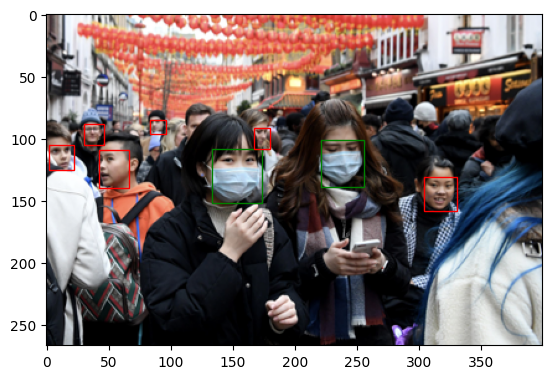

Prediction :  tensor([2, 2, 1, 1, 1, 1, 1, 1, 2])


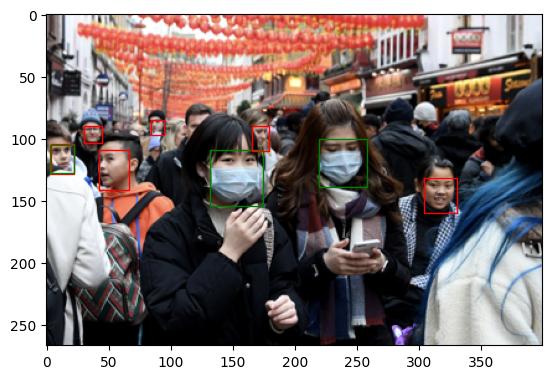

In [27]:
_idx = 1

target_annotation_cpu = {k: v.cpu().detach() for k, v in annotations[_idx].items()}
print("Target : ", target_annotation_cpu['labels'])
plot_image_from_output(imgs[_idx].cpu().detach().permute(1, 2, 0), target_annotation_cpu)

pred_annotation_cpu = {k: v.cpu().detach() for k, v in pred[_idx].items()}
print("Prediction : ", pred_annotation_cpu['labels'])
plot_image_from_output(imgs[_idx].cpu().detach().permute(1, 2, 0), pred_annotation_cpu)

- Target 이 실제 바운딩 박스 위치이며, Pred 가 예측 결과 (모델이 실제 객체에 해당하는 바운딩 박스 위치를 잘 찾은 것으로 보임)

Target :  tensor([2])


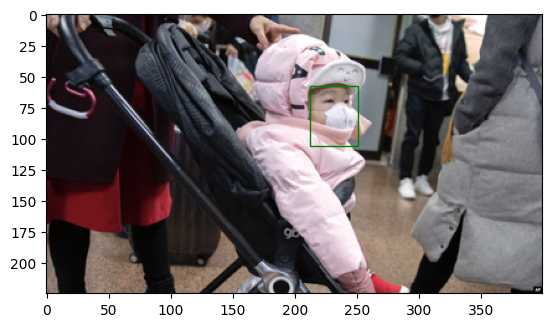

Prediction :  tensor([2, 2])


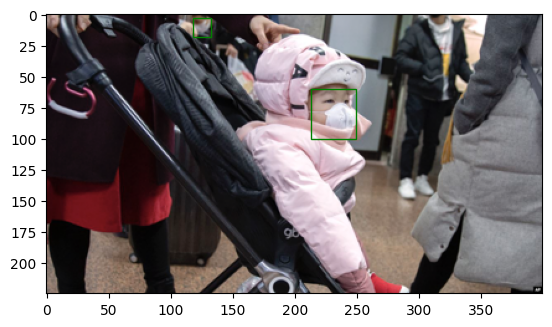

In [34]:
_idx = 0

target_annotation_cpu = {k: v.cpu().detach() for k, v in annotations[_idx].items()}
print("Target : ", target_annotation_cpu['labels'])
plot_image_from_output(imgs[_idx].cpu().detach().permute(1, 2, 0), target_annotation_cpu)

pred_annotation_cpu = {k: v.cpu().detach() for k, v in pred[_idx].items()}
print("Prediction : ", pred_annotation_cpu['labels'])
plot_image_from_output(imgs[_idx].cpu().detach().permute(1, 2, 0), pred_annotation_cpu)

In [35]:
pred[0]

{'boxes': tensor([[213.5001,  59.6581, 249.4690, 100.4841],
         [118.2289,   2.5378, 132.2308,  18.1899]], device='cuda:0'),
 'labels': tensor([2, 2], device='cuda:0'),
 'scores': tensor([0.9482, 0.8401], device='cuda:0')}

- 첫 번째 이미지는 추가로 잘못 인식된 마운딩 박스가 보임.